# Project 4: West Nile Virus Analysis


This project is documented into the following notebooks:

- Part 1: Data Cleaning and EDA

- Part 2: Modeling and Evaluation

## Part 1 - Data Cleaning and EDA

## INTRODUCTION

West Nile Virus(WNV) is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from persistent fever to serious neurological illnesses that can result in death. In 2002, the first human cases of WNV were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.

Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.

Project based on: https://www.kaggle.com/c/predict-west-nile-virus/overview


### Problem Statement

**Due to the recent epidemic of West Nile Virus in the Windy City, the data science team at Disease And Treatment Agency was tasked to derive an effective plan to spray pesticides throughout the city.
Using various weather conditions and time lags, we will be analysing classification models to obtain the best model that can predict the presence of WNV in Chicago, which the department can use to plan spray.


### Executive Summary

The purpose of this project is to identify key areas in the city that are prone to virus and provide solutions to current problems and future prevention measures. Number of traps are scattered across the city, which traps mosquitoes that the city can use to determine if the area has West Nile Virus or not. The dataset is made available throught the kaggle competition, and using the years 2007, 2009, 2011 and 2013, we are asked to predict the presence of the virus for years 2008, 2010, 2012 and 2014. Additionally, we are given weather and some spray data.

The training data has two columns that the test does not, which can be our potential target variables $-$ _NumMosquitos and WnvPresent_. It also contains the coodinates for the traps and species of mosquitos in the trap. Then we do some exploratory data analysis on the train, weather and spray data, to identify any patterns and draw insights about the data. One thing that is not quite right with the dataset is that the column _NumMosquitos_ is capped at 50 and any additional number is added to the next row in the train data. This creates duplicate rows, so we can choose to combine them so as to not overfit the model, but we cannot drop the duplicate rows for test because the test dataset has a unique ID for each observations and we are expected to predict for each one.

This is followed by cleaning and imputing the different datasets to combine them into one dataframe which is used to train the model in the next part of this project. Since the goal is to predict the presence of the virus, it becomes a binary classification problem, so we use models that are common for such predictions, like Logistic Regression, tree based models like Extra Trees and Random Forest, and boosted models like AdaBoost and XGBoost classifiers. We picked our model based on the highest 'ROC-AUC' score and 'Recall' score obtained on the validation set to predict the test set. 


**Evaluation**

The most common metric for classification problems is accuracy. But some times, accuracy can give a fake sense of success, especially when measured on highly unbalanced classes like in this project. Say our target class distribution is 98-2, then predicting every target equal to majority class gives us 98% accuracy, which is not realistic. Thus, we can look at other widely used metric, ROC-AUC, which can give us more information because it plots true positive rate vs false positive rate. Intuitively, it explains how good the model is at separating the two classes. In this project, it is crucial to reduce the number of observations that are predicted to not have the virus when they actually have. To maximise the help we can provide to the city authorities, it is imperative that we don't miss many sites which might have the virus.

#### Contents

- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Export Cleaned Data](#Export-Cleaned-Data)

## Data Cleaning

In this section, we will look at the 4 datasets closely and describe the initial observations that we find. Then we will proceed to clean the data by looking at duplicate values, null values and imputing them where necessary and conduct feature engineering.

Import all necessary libraries.

In [1]:
#import all required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer

Read in all the datafiles.

In [2]:
#import all datafiles
spray = pd.read_csv('../datasets/spray.csv', parse_dates=['Date'])
test = pd.read_csv('../datasets/test.csv', parse_dates=['Date'])
train = pd.read_csv('../datasets/train.csv', parse_dates=['Date'])
weather = pd.read_csv('../datasets/weather.csv', parse_dates=['Date'])

Standardise column name format amongst all columns.

First we will create a function to standardise column names.

In [3]:
#function to standardise column names amongst all datasets
def rename_cols(df):
    df.columns = df.columns.str.replace('(?<=[a-z0-9])(?=[A-Z])', '_', regex=True).str.lower()

In [4]:
#rename all columns in the datasets
rename_cols(train)
rename_cols(test)
rename_cols(weather)
rename_cols(spray)

The function below provides an overview of the dataset which will be used when we look at the datasets individually.

In [5]:
#function to look at overview of df
def df_overview(df):
    print(f'Number of rows: {df.shape[0]}')
    print(f'Number of columns: {df.shape[1]}')
    print('\nNames of columns in dataset.')    
    display(df.columns)
    display(df.dtypes)
    print('Missing values in dataset')
    display(df.isnull().sum())
    print(f'Number of duplicate values in dataset: {df[df.duplicated(keep=False)].shape[0]}')

We will proceed to analyse the each dataset individually.

### Train Dataset

The training set consists of data from 2007, 2009, 2011, and 2013.

#### Overview of Train Dataset

In [6]:
train.head()

,date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy,num_mosquitos,wnv_present
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


Let us look at the overview of the train dataset.

In [7]:
df_overview(train)

Number of rows: 10506
Number of columns: 12

Names of columns in dataset.


Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'address_number_and_street', 'latitude', 'longitude',
       'address_accuracy', 'num_mosquitos', 'wnv_present'],
      dtype='object')

date                         datetime64[ns]
address                              object
species                              object
block                                 int64
street                               object
trap                                 object
address_number_and_street            object
latitude                            float64
longitude                           float64
address_accuracy                      int64
num_mosquitos                         int64
wnv_present                           int64
dtype: object

Missing values in dataset


date                         0
address                      0
species                      0
block                        0
street                       0
trap                         0
address_number_and_street    0
latitude                     0
longitude                    0
address_accuracy             0
num_mosquitos                0
wnv_present                  0
dtype: int64

Number of duplicate values in dataset: 1062


#### Duplicates

As the number of mosquitos in each row are capped at 50, traps with more than 50 mosquitos will have multiple rows and therefore a high number of duplicates.

In [8]:
train[train.duplicated(keep=False)]

,date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy,num_mosquitos,wnv_present
98,2007-06-26,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,1,0
99,2007-06-26,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,1,0
293,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,50,0
295,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,50,0
350,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.682587,-87.707973,9,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10124,2013-09-06,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,50,1
10259,2013-09-12,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,50,0
10262,2013-09-12,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,50,0
10391,2013-09-19,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,13,0


However, there are rows where the number of mosquitos is less than 50 and still have duplicated rows i.e. 98 and 99. Hence we will drop these rows.

In [9]:
train.drop(index = train[(train.duplicated(keep=False)) & (train['num_mosquitos'] <50)].index, inplace = True)

#### Traps

Traps are described by block and street names. However we do have the longitude and latitude of the traps which provide the exact location of the traps. Hence we will drop columns describing the address.

In [10]:
train.columns

Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'address_number_and_street', 'latitude', 'longitude',
       'address_accuracy', 'num_mosquitos', 'wnv_present'],
      dtype='object')

In [11]:
train.drop(columns = {'address', 'block', 'street', 'address_number_and_street', 'address_accuracy'}, inplace = True)

In [12]:
train.head()

,date,species,trap,latitude,longitude,num_mosquitos,wnv_present
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0


#### Number of Mosquitos and Presence of Virus

As mentioned, the number of mosquitos in each row are capped at 50 and there are traps with more than 50 mosquitos. Let us look at the traps with mosquitos more than 50. 

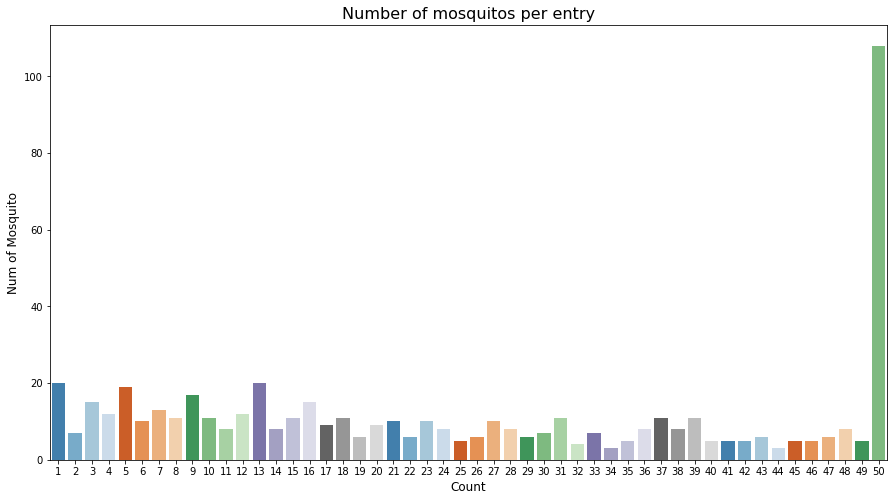

In [13]:
# plot only the number of mosquitos in trap if the virus was detected
plt.figure(figsize=(15, 8))
plt.title("Number of mosquitos per entry", fontdict={'fontsize': 16})
sns.countplot(data=train[train['wnv_present'] == 1], x='num_mosquitos', palette='tab20c')
plt.xlabel('Count', fontdict={'fontsize': 12})
plt.ylabel('Num of Mosquito', fontdict={'fontsize': 12});

The above plot confirms that there is no obvious trend between the virus being detected in the trap and the number of mosquitos in that trap, except at 50, which is because the data entries are capped.

In [14]:
train[((train['num_mosquitos'] == 50) & (train['wnv_present'] == 0)) | ((train['num_mosquitos'] == 50) & (train['wnv_present'] == 1))].tail(20)

,date,species,trap,latitude,longitude,num_mosquitos,wnv_present
9988,2013-08-29,CULEX PIPIENS,T900,41.974689,-87.890615,50,1
9992,2013-08-29,CULEX PIPIENS,T900,41.974689,-87.890615,50,1
10011,2013-08-29,CULEX PIPIENS/RESTUANS,T233,42.009876,-87.807277,50,1
10012,2013-08-29,CULEX PIPIENS/RESTUANS,T233,42.009876,-87.807277,50,0
10013,2013-08-29,CULEX PIPIENS/RESTUANS,T233,42.009876,-87.807277,50,1
10014,2013-08-29,CULEX PIPIENS,T233,42.009876,-87.807277,50,1
10020,2013-09-06,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,50,0
10029,2013-09-06,CULEX PIPIENS/RESTUANS,T054,41.921965,-87.632085,50,1
10031,2013-09-06,CULEX PIPIENS,T054,41.921965,-87.632085,50,1
10044,2013-09-06,CULEX PIPIENS,T033,41.906638,-87.701431,50,0


Just by looking at the data above, we are able to see traps that have more than 50 mosquitos but have virus present only in some of the rows. Additionally, we see numerous number of duplicated rows, such as index = 9988 and index = 9992.

In [15]:
train[(train['trap'] == 'T002') & (train['date'] == '2009-07-24')]

,date,species,trap,latitude,longitude,num_mosquitos,wnv_present
4888,2009-07-24,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,50,0
4889,2009-07-24,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,25,0
4890,2009-07-24,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,50,1
4891,2009-07-24,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,50,0
4892,2009-07-24,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,40,0
4893,2009-07-24,CULEX RESTUANS,T002,41.95469,-87.800991,18,0
4894,2009-07-24,CULEX PIPIENS,T002,41.95469,-87.800991,4,0


For trap T115 on 2013-09-12, we see only some rows indicating presence of virus even though they belong to the same trap and are recorded on the same date. We also have to keep in mind that traps are placed at strategic locations and not all mosquitos can be captured by the traps. Although each row is capped at 50, the mosquitos are still taken from the same trap. Hence we will classify these traps as '1' if there are some bins with virus present.

In [16]:
train = train.groupby([column for column in train.columns \
                       if column not in ['num_mosquitos','wnv_present']]).sum().reset_index()
train['wnv_present'] = train['wnv_present'].map(lambda x: 1 if x > 0 else 0)

In [17]:
train

,date,species,trap,latitude,longitude,num_mosquitos,wnv_present
0,2007-05-29,CULEX PIPIENS,T096,41.731922,-87.677512,1,0
1,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0
2,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,0
4,2007-05-29,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,0
...,...,...,...,...,...,...,...
8423,2013-09-26,CULEX RESTUANS,T082,41.803423,-87.642984,2,0
8424,2013-09-26,CULEX RESTUANS,T102,41.750498,-87.605294,1,0
8425,2013-09-26,CULEX RESTUANS,T209,41.740641,-87.546587,1,0
8426,2013-09-26,CULEX RESTUANS,T220,41.963976,-87.691810,8,0


In [18]:
train.shape

(8428, 7)

This removes all our duplicated rows as well.

### Test Dataset

We will implement all the structural changes that we did in our Train dataset to our Test dataset as well.

The test data contains data for the years 2008, 2010, 2012, and 2014.

#### Overview of Test Dataset

In [19]:
df_overview(test)

Number of rows: 116293
Number of columns: 11

Names of columns in dataset.


Index(['id', 'date', 'address', 'species', 'block', 'street', 'trap',
       'address_number_and_street', 'latitude', 'longitude',
       'address_accuracy'],
      dtype='object')

id                                    int64
date                         datetime64[ns]
address                              object
species                              object
block                                 int64
street                               object
trap                                 object
address_number_and_street            object
latitude                            float64
longitude                           float64
address_accuracy                      int64
dtype: object

Missing values in dataset


id                           0
date                         0
address                      0
species                      0
block                        0
street                       0
trap                         0
address_number_and_street    0
latitude                     0
longitude                    0
address_accuracy             0
dtype: int64

Number of duplicate values in dataset: 0


#### Clean Test Dataset

We will clean the dataset based on our train dataset to ensure that the structures are the same when we proceed to model our data.

In [20]:
test.drop(columns = {'id', 'address', 'block', 'street', 
                     'address_number_and_street', 'address_accuracy'}, inplace = True)

In [21]:
test

,date,species,trap,latitude,longitude
0,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991
1,2008-06-11,CULEX RESTUANS,T002,41.954690,-87.800991
2,2008-06-11,CULEX PIPIENS,T002,41.954690,-87.800991
3,2008-06-11,CULEX SALINARIUS,T002,41.954690,-87.800991
4,2008-06-11,CULEX TERRITANS,T002,41.954690,-87.800991
...,...,...,...,...,...
116288,2014-10-02,CULEX SALINARIUS,T054C,41.925652,-87.633590
116289,2014-10-02,CULEX TERRITANS,T054C,41.925652,-87.633590
116290,2014-10-02,CULEX TARSALIS,T054C,41.925652,-87.633590
116291,2014-10-02,UNSPECIFIED CULEX,T054C,41.925652,-87.633590


### Weather Dataset

#### Overview of Weather Dataset

The weather dataset is taken from two stations from years 2007 to 2014.

In [22]:
weather.head(10)

,station,date,tmax,tmin,tavg,depart,dew_point,wet_bulb,heat,cool,...,code_sum,depth,water1,snow_fall,precip_total,stn_pressure,sea_level,result_speed,result_dir,avg_speed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
5,2,2007-05-03,67,48,58,M,40,50,7,0,...,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
6,1,2007-05-04,66,49,58,4,41,50,7,0,...,RA,0,M,0.0,T,29.31,30.05,10.4,8,10.8
7,2,2007-05-04,78,51,M,M,42,50,M,M,...,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
8,1,2007-05-05,66,53,60,5,38,49,5,0,...,,0,M,0.0,T,29.40,30.10,11.7,7,12.0
9,2,2007-05-05,66,54,60,M,39,50,5,0,...,,M,M,M,T,29.46,30.09,11.2,7,11.5


In [23]:
df_overview(weather)

Number of rows: 2944
Number of columns: 22

Names of columns in dataset.


Index(['station', 'date', 'tmax', 'tmin', 'tavg', 'depart', 'dew_point',
       'wet_bulb', 'heat', 'cool', 'sunrise', 'sunset', 'code_sum', 'depth',
       'water1', 'snow_fall', 'precip_total', 'stn_pressure', 'sea_level',
       'result_speed', 'result_dir', 'avg_speed'],
      dtype='object')

station                  int64
date            datetime64[ns]
tmax                     int64
tmin                     int64
tavg                    object
depart                  object
dew_point                int64
wet_bulb                object
heat                    object
cool                    object
sunrise                 object
sunset                  object
code_sum                object
depth                   object
water1                  object
snow_fall               object
precip_total            object
stn_pressure            object
sea_level               object
result_speed           float64
result_dir               int64
avg_speed               object
dtype: object

Missing values in dataset


station         0
date            0
tmax            0
tmin            0
tavg            0
depart          0
dew_point       0
wet_bulb        0
heat            0
cool            0
sunrise         0
sunset          0
code_sum        0
depth           0
water1          0
snow_fall       0
precip_total    0
stn_pressure    0
sea_level       0
result_speed    0
result_dir      0
avg_speed       0
dtype: int64

Number of duplicate values in dataset: 0


#### Null Values

Although there are no null values, they are represented differently as stated in the documentation. 

'M' = missing values (for e.g. in Tavg column)<br>
'-' = missing values (for e.g. in Sunrise column)<br>
' ' = moderate (for CodeSum column)<br>
'T' = trace values (for e.g. PrecipTotal column)<br>


Let us look at all the null values again.

In [24]:
weather.isin(['M', '-', '  T']).sum().sort_values(ascending=False)

water1          2944
snow_fall       1484
sunrise         1472
depth           1472
depart          1472
sunset          1472
precip_total     320
heat              11
tavg              11
cool              11
sea_level          9
stn_pressure       4
wet_bulb           4
avg_speed          3
result_dir         0
dew_point          0
code_sum           0
result_speed       0
tmin               0
tmax               0
date               0
station            0
dtype: int64

'water1' feature has null values for all rows in the dataset. Hence we will drop this feature.

In [25]:
weather.groupby('station')['snow_fall'].value_counts()

station  snow_fall
1        0.0          1459
           T            12
         0.1             1
2        M            1472
Name: snow_fall, dtype: int64

Seems that the values from both stations are either missing or 0, or do not provide any useful insights that can help us predict the virus, hence we will drop this feature.

In [26]:
weather.groupby('station')['sunset'].value_counts()

station  sunset
1        1931        96
         1930        56
         1929        48
         1923        32
         1925        32
                   ... 
         1900         8
         1901         8
         1905         8
         1912         8
2        -         1472
Name: sunset, Length: 119, dtype: int64

Given any day, the sunset from both weather stations will be the same, hence we will impute based on the time given at one station.

In [27]:
weather.groupby('station')['depth'].value_counts()

station  depth
1        0        1472
2        M        1472
Name: depth, dtype: int64

'Depth' feature has either 0 or missing values as well for both stations, so we will drop this feature.

In [28]:
weather.groupby('station')['depart'].value_counts()

station  depart
1         2          93
         -1          84
         -2          80
          5          77
          1          76
          7          76
          3          75
          0          74
         -3          72
          4          71
          6          67
          8          59
         -5          57
         -4          56
         -6          50
          9          47
         10          46
         -8          43
         -7          30
         11          28
         12          28
         -9          25
         13          23
         -10         22
         14          22
         15          15
         16          12
         -11         10
         -12          8
         17           7
         -14          6
         18           6
         -13          5
         19           4
         20           4
         -15          3
         -16          3
         22           3
         -17          2
         21           2
         23           1


We can impute station 2's temperature departure from normal based on station's 1 as well.

In [29]:
weather.groupby('station')['sunrise'].value_counts()

station  sunrise
1        0416        104
         0417         64
         0419         40
         0418         32
         0420         32
                    ... 
         0619          8
         0620          8
         0622          8
         0623          8
2        -          1472
Name: sunrise, Length: 122, dtype: int64

Just like sunset, we can impute station 2's sunrise from station 1's values.

In [30]:
weather.groupby('station')['precip_total'].value_counts()

station  precip_total
1        0.00            794
           T             163
         0.01             54
         0.02             30
         0.03             20
                        ... 
2        3.15              1
         3.17              1
         3.31              1
         3.66              1
         4.73              1
Name: precip_total, Length: 256, dtype: int64

For 'T' values, we will replace with trace value as 0.005.

For 'tavg', 'heat', 'cool', 'sea level', 'stn_pressure', 'wet_bulb', 'avg_speed' features, we will impute based on either the other station's value or other calculations based on other features which will be done in the next section.

As we have analysed, 'water1', 'snow_fall' and 'depth' do not provide us with sufficient information to predict presence of the virus and have too many null values, hence we are dropping these columns.

In [31]:
weather.drop(columns = {'water1', 'snow_fall', 'depth'}, inplace = True)

#### Null Imputation

Imputing values based on other station's values for the 'sunrise', 'sunset', 'depart' and 'avg_speed' features.

For 'sunrise' and 'sunset', we will impute using station 1's value.

In [32]:
#function to impute sunrise and sunset based on other station's values
def fill_sunrisesunset(row):
    
    if row['sunrise'] == '-': 
        row['sunrise'] = weather.loc[(weather['date'] == row['date']) & \
                                    (weather['station'] == 1), 'sunrise'].values[0]
    if row['sunset'] == '-':
        row['sunset'] = weather.loc[(weather['date'] == row['date']) & \
                                    (weather['station'] == 1), 'sunset'].values[0]
    return row

In [33]:
weather = weather.apply(fill_sunrisesunset, axis=1)

Imputing trace value for 'precip_total' feature.

In [34]:
weather['precip_total'].replace('  T', 0.005, inplace = True)
weather['precip_total'].replace('M', 0, inplace = True)

Impute 'tavg' by taking average of tmax and tmin.

In [35]:
#function to impute average temperature using tmax and tmin
def fill_tavg(row):
    if row['tavg'] == 'M':
        row['tavg'] = round((row['tmax'] + row['tmin']) / 2)
    return row

In [36]:
weather = weather.apply(fill_tavg, axis=1)

Departure from normal is the difference between the average temperature 'tavg' and the 30 year normal temperature for that day. A minus (-) is number of degrees below normal. A zero (0) indicates that the average for that day was the Normal.

Station 1:
depart1 + averagetemp1 = 30 year normal

Station 2:
depart2 + averagetemp2 = 30 year normal

depart2 = depart1 + averagetemp1 - averagetemp2

To impute the values for 'depart' for Station 2, we will add the values of 'depart' and 'tavg' for Station 1 and subtract the 'tavg' for station 2.

In [37]:
#function to impute depart
def fill_depart(row):
    if row['station'] == 2:
        row['depart'] = int(weather.loc[(weather['date'] == row['date']) &
                      (weather['station'] == 1), 'depart']) + int(weather.loc[(weather['date'] == row['date']) &
                      (weather['station'] == 1), 'tavg']) - int(row['tavg'])
    return row

In [38]:
weather = weather.apply(fill_depart, axis=1)

The 'heating' and 'cooling' features are derived from the taking the difference between the 'tavg' and base temperature of 65 F. If the difference is positive, it is classified as 'heating' and vice versa.

In [39]:
#function to impute heat and cool
def fill_heatcool(row):
    
    if row['heat'] == 'M' or row['cool'] == 'M':
        
        difference = 65 - float(row['tavg'])
        
        if difference > 0: 
            row['heat'] = difference
            row['cool'] = 0
        elif difference < 0:
            row['heat'] = 0
            row['cool'] = difference
        else:
            row['heat'] = row['cool'] = 0
    
    return row

In [40]:
weather = weather.apply(fill_heatcool, axis=1)

Impute 'sea_level' and 'stn_pressure' by looking at previous day and next day values.

In [41]:
#function to impute previous and next day values (for any numerical column)
def fill_prevnext(col_name):
    for index, row in weather.loc[weather[col_name].isin(['M'])].iterrows():
        inter = (float(weather.iloc[(index - 2)][col_name]) + float(weather.iloc[(index + 2)][col_name])) / 2
        weather.at[index, col_name] = round(inter, 2) 

In [42]:
fill_prevnext('sea_level')
fill_prevnext('stn_pressure')


Impute avg_speed and wet_bulb based on other station's values.

In [43]:
#function to impute average speed and wetbulb based on other station's values
def fill_speedwetbulb(row):
    if row['avg_speed'] == 'M': 
        if row['station'] == 1:
            row['avg_speed'] = weather.loc[(weather['date'] == row['date']) & \
                                    (weather['station'] == 2), 'avg_speed'].values[0]
        else: 
            row['avg_speed'] = weather.loc[(weather['date'] == row['date']) & \
                                    (weather['station'] == 1), 'avg_speed'].values[0]
    if row['wet_bulb'] == 'M': 
        if row['station'] == 1:
            row['wet_bulb'] = weather.loc[(weather['date'] == row['date']) & \
                                    (weather['station'] == 2), 'wet_bulb'].values[0]
        else: 
            row['wet_bulb'] = weather.loc[(weather['date'] == row['date']) & \
                                    (weather['station'] == 1), 'wet_bulb'].values[0]
    return row

In [44]:
weather = weather.apply(fill_speedwetbulb, axis=1)

In [45]:
#check if all null values have been imputed
weather.isin(['M', '-', '  T']).sum()

station         0
date            0
tmax            0
tmin            0
tavg            0
depart          0
dew_point       0
wet_bulb        0
heat            0
cool            0
sunrise         0
sunset          0
code_sum        0
precip_total    0
stn_pressure    0
sea_level       0
result_speed    0
result_dir      0
avg_speed       0
dtype: int64

**Change datatypes**

In [46]:
# convert objects to numeric type
cols_to_floats = ['tavg', 'precip_total', 'stn_pressure', 'sea_level', 'avg_speed', 'heat', 'cool']
cols_to_int = ['wet_bulb', 'sunrise', 'sunset', 'depart']
for col in weather.columns:
    if col in cols_to_floats:
        weather[col] = weather[col].astype(float)
    if col in cols_to_int:
        weather[col] = weather[col].astype(int)

In [47]:
weather.dtypes

station                  int64
date            datetime64[ns]
tmax                     int64
tmin                     int64
tavg                   float64
depart                   int64
dew_point                int64
wet_bulb                 int64
heat                   float64
cool                   float64
sunrise                  int64
sunset                   int64
code_sum                object
precip_total           float64
stn_pressure           float64
sea_level              float64
result_speed           float64
result_dir               int64
avg_speed              float64
dtype: object

#### Daylight

'sunrise' and 'sunset' features only provide us with the time of the day and do not provide us with insightful information about the daylight in a day. Instead we will create a feature called 'daylight' which is more insightful in explaining the relationships between amount of light and presence of mosquitos in an area. The 'daylight' feature will be in minutes.

To do this, we will first convert sunrise and sunset to minutes from start of day, and subtract the values to find the total minutes of daylight.

In [48]:
#function to convert time to minutes from 12:00 am
def convert_mins(row):
    #get hour
    hour = row//100
    mins = row % 100
    total = hour * 60 + mins
    return total

In [49]:
weather['sunrise'] = weather['sunrise'].apply(convert_mins)
weather['sunset'] = weather['sunset'].apply(convert_mins)

In [50]:
#total daylight experienced in a day
weather['daylight'] = weather['sunset'] - weather['sunrise']

In [51]:
weather.drop(columns = {'sunrise', 'sunset'}, inplace = True)

#### Relative Humidity 

Relative humidity refers to the moisture content (water vapor) in the atmosphere, at constant temperature and pressure.

Relative Humidity = (e(17.625 * temp degC)/ (temp degC +243.04)) / (e(17.625 * dew degC)/ (dew degC +243.04)) * 100

In [52]:
#convert tavg and dewpoint to degrees Celsius first
tavg_degC = ((weather['tavg'] - 32) * 5 / 9)
dew_degC = ((weather['dew_point'] - 32) * 5 / 9)

r_humid = np.exp((17.625 * tavg_degC)/(tavg_degC +243.04)) / np.exp((17.625 * dew_degC)/(dew_degC +243.04)) * 100

In [53]:
weather['r_humid'] = r_humid

#### Averaging Stations

The weather stations provide us with weather information at two different locations. However, as the stations are placed close together, we can use a combined dataset to look at an overview of the weather in the entire targeted area.


Therefore, we will merge and take the average from both stations.

In [54]:
weather_merged = weather.groupby('date').mean()

In [55]:
weather_merged = weather_merged.reset_index()

In [56]:
weather_merged.drop(columns ='station', inplace = True)

Add CodeSum back into merged dataframe.

Before that we are going to combine the 'codesum' feature values in both stations before we add to the merged dataframe.

In [57]:
weather['code_sum'] = weather['code_sum'].str.replace("BCFG","BC FG")
weather['code_sum'] = weather['code_sum'].str.replace("MIFG","MI FG")
weather['code_sum'] = weather['code_sum'].str.replace("TSRA","TS RA")
weather['code_sum'] = weather['code_sum'].str.replace("VCFG","VC FG")
weather['code_sum'] = weather['code_sum'].str.replace("VCTS","VC TS")

In [58]:
#function to combine codesum for both columns
def combine_codesum(codesum):
    combine = " ".join(codesum) 
    combine = combine.split() 
    distinct = set(combine)
    join_list = " ".join(distinct)
    return join_list

In [59]:
combined_codesum = weather.groupby('date')['code_sum'].agg(combine_codesum)

Create dummy variables for codesum using Count Vectorizer.

In [60]:
#instantiate count vectorizer and fit code sum list
cvec = CountVectorizer(analyzer='word', token_pattern=r'[\w\+]+')
cs_cvec = cvec.fit_transform(combined_codesum.tolist())

In [61]:
#convert to dataframe
df = pd.DataFrame(cs_cvec.toarray(), columns=cvec.get_feature_names())

In [62]:
#final weather data
weather_final = pd.concat([weather_merged, df.reset_index(drop=True)], axis=1)

In [63]:
pd.set_option('display.max_columns', None)
weather_final.head()

,date,tmax,tmin,tavg,depart,dew_point,wet_bulb,heat,cool,precip_total,stn_pressure,sea_level,result_speed,result_dir,avg_speed,daylight,r_humid,bc,br,dz,fg,fg+,fu,gr,hz,mi,ra,sn,sq,ts,vc
0,2007-05-01,83.5,51.0,67.5,13.5,51.0,56.5,0.0,2.5,0.0000,29.140,29.820,2.20,26.0,9.40,841.0,180.290544,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2007-05-02,59.5,42.5,51.5,-3.5,42.0,47.0,13.5,0.0,0.0000,29.410,30.085,13.15,3.0,13.40,843.0,143.099258,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,2007-05-03,66.5,47.0,57.0,1.0,40.0,49.0,8.0,0.0,0.0000,29.425,30.120,12.30,6.5,12.55,845.0,189.044811,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2007-05-04,72.0,50.0,61.0,1.0,41.5,50.0,4.0,0.0,0.0025,29.335,30.045,10.25,7.5,10.60,848.0,206.316156,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2007-05-05,66.0,53.5,60.0,5.0,38.5,49.5,5.0,0.0,0.0050,29.430,30.095,11.45,7.0,11.75,850.0,223.086078,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Spray Dataset

The spray dataset contains the spraying efforts conducted in 2011 and 2013.

#### Overview of Spray Dataset

In [64]:
df_overview(spray)

Number of rows: 14835
Number of columns: 4

Names of columns in dataset.


Index(['date', 'time', 'latitude', 'longitude'], dtype='object')

date         datetime64[ns]
time                 object
latitude            float64
longitude           float64
dtype: object

Missing values in dataset


date           0
time         584
latitude       0
longitude      0
dtype: int64

Number of duplicate values in dataset: 543


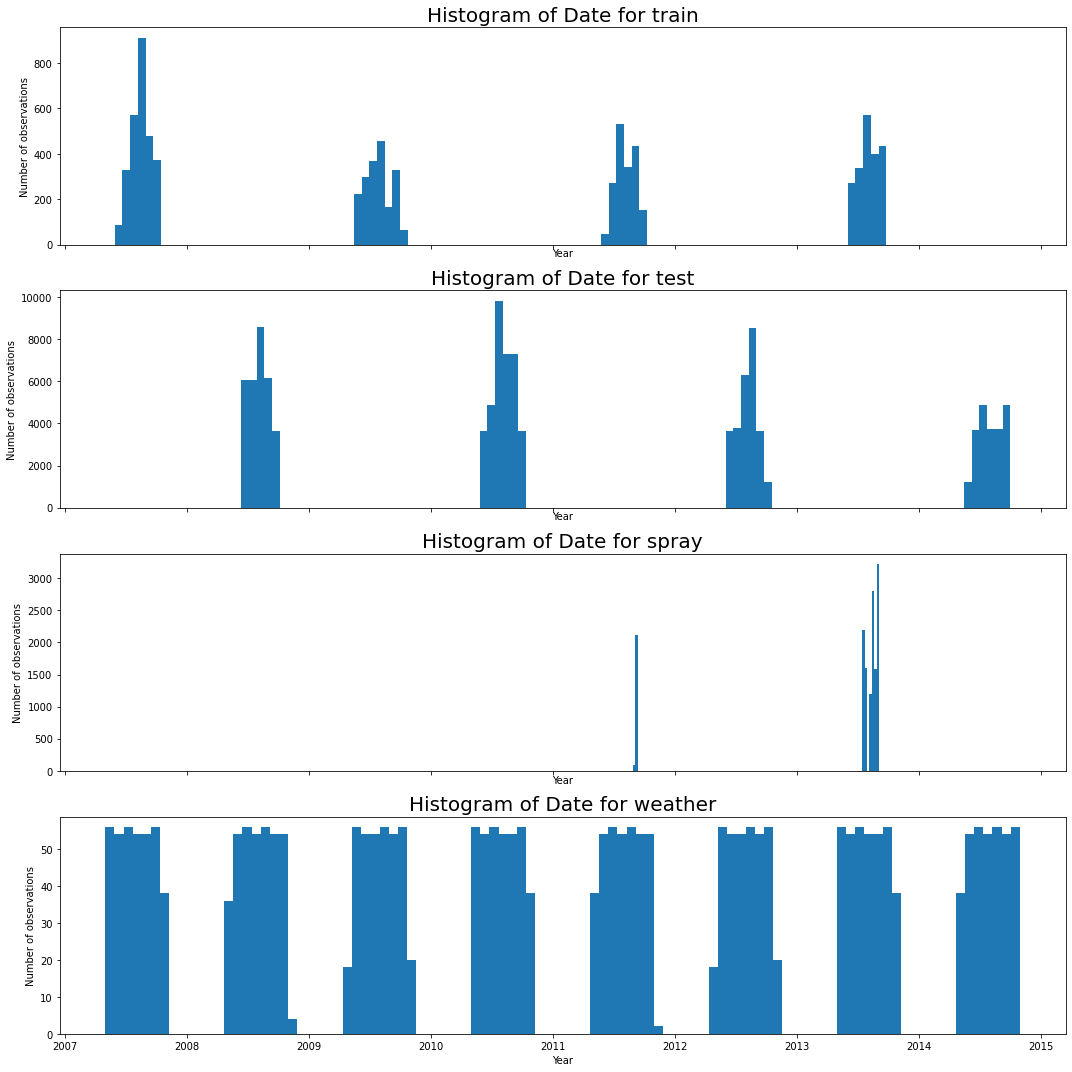

In [65]:
# Histogram of the dates for the different datasets
fig, ax = plt.subplots(4, 1, figsize=(15, 15), sharex=True)
df_name = [train, test, spray, weather]
title_name = ['train', 'test', 'spray', 'weather']

for i, df in enumerate(df_name):
    ax[i].hist(df['date'], bins=100)
    ax[i].set_title(f'Histogram of Date for {title_name[i]}', size=20)
    ax[i].set_xlabel('Year')
    ax[i].set_ylabel('Number of observations')
plt.tight_layout()

We can see that the date collection of datesets are different for the different datasets. Spray dataset has the least number of data. Train and test data collection are mutually exclusive. Weather dataset's dates covered most of the train and test dataset. 

**Columns to Drop**

There are missing values in the time feature that we cannot impute and all of our other datasets only consist of Date and not time, we will drop the time feature.

In [66]:
spray.drop(columns = 'time', inplace = True)

## Exploratory Data Analysis

Now that we have cleaned our data, in this section we will conduct EDA on our cleaned datasets. We will explore how the features from the datasets are related to each other and how they influence our target variable.

### Train Dataset

#### Species of Mosquitos

Let us look at the presence of virus in the different species of mosquitos.

In [67]:
train.groupby('species')\
[['num_mosquitos','wnv_present']].sum().reset_index().sort_values(by='num_mosquitos',ascending=False)

,species,num_mosquitos,wnv_present
2,CULEX PIPIENS/RESTUANS,65419,224
1,CULEX PIPIENS,44305,184
3,CULEX RESTUANS,23223,48
6,CULEX TERRITANS,506,0
4,CULEX SALINARIUS,143,0
0,CULEX ERRATICUS,7,0
5,CULEX TARSALIS,7,0


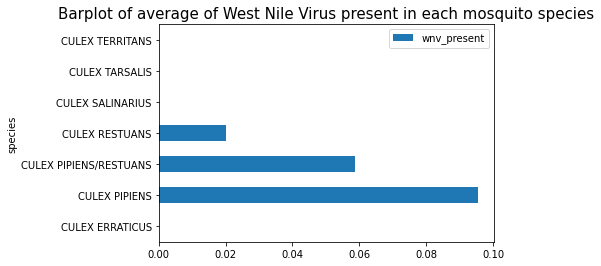

In [68]:
train.groupby(['species'])[['wnv_present']].mean().plot.barh()
plt.title('Barplot of average of West Nile Virus present in each mosquito species', size=15);

Observations show that virus was promininetly found in 3 species, 'Culex Pipiens', 'Culex Pipiens/Restuans' and 'Culex Restuans'. 'Culex Pipiens/Restuans' also had the largest number of mosquitos collected followed by 'Culex Pipens' and 'Culex Pipiens/Restuans'. 

The graphs above represent the total number of mosquitos and presence of virus for all the years in our dataset. As we see no presence of virus and low number of mosquitos collected for the other species. We will one hot encode these species.

0 - All other species
1 - Culex Restuans
2 - Culex Pipiens/Restuans
3 - Culex Pipiens

In [69]:
#one hot encoding for top 3 species
train['species_ohe'] = train['species'].map(
    {'CULEX RESTUANS': 1, 'CULEX PIPIENS/RESTUANS': 2, 'CULEX PIPIENS': 3})
#0 for all other species
train['species_ohe'].fillna(0, inplace=True)

#### Traps

Traps by number of mosquitos collected

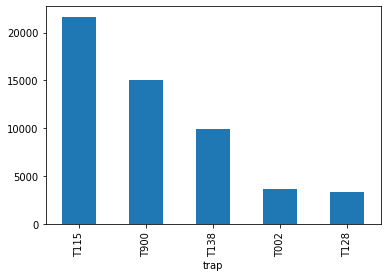

In [70]:
train.groupby(['trap'])['num_mosquitos'].sum().sort_values(ascending=False).head().plot(kind = 'bar');

Traps by number of times sampled.

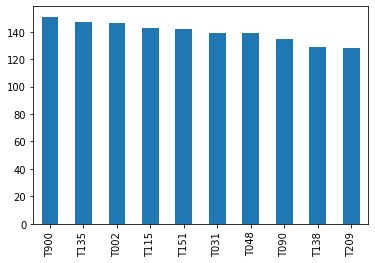

In [71]:
train['trap'].value_counts(ascending=False).head(10).plot(kind='bar');

Traps 'T115' and 'T900' have collected the most number of mosquitos over the years and the 'T900' also seemed to be sampled the most.

In [72]:
display(train.trap.nunique())
display(test.trap.nunique())
display(train.loc[:, ('latitude', 'longitude')].nunique())
display(test.loc[:, ('latitude', 'longitude')].nunique())

136

149

latitude     138
longitude    138
dtype: int64

latitude     151
longitude    151
dtype: int64

In [73]:
set(test['trap'].unique()) ^ set(train['trap'].unique())

{'T002A',
 'T002B',
 'T065A',
 'T090A',
 'T090B',
 'T090C',
 'T128A',
 'T200A',
 'T200B',
 'T218A',
 'T218B',
 'T218C',
 'T234'}

The number of traps and the exact location that we have do not match. As traps are not in the same position, traps would be drop. In addtion, test and train dataset have different trap numbers as well.

In [74]:
train['year'] = train['date'].apply(lambda x: x.year)
train['month'] = train['date'].apply(lambda x: x.month)

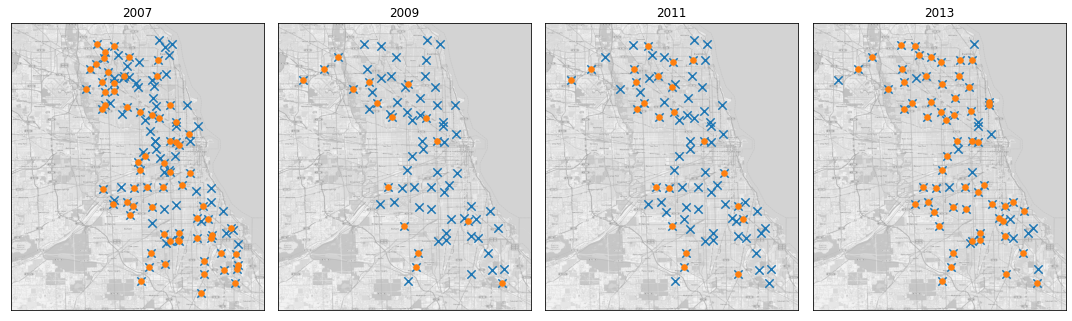

In [75]:
# Code is adapted from: https://www.kaggle.com/jbobtaylor/show-map-image-in-python
mapdata = np.loadtxt("../datasets//mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]

# trap locations in latitude and longitudes
trap_loc = train.drop_duplicates('trap')[['trap','longitude', 'latitude', 'wnv_present']]

# to create the map boundaries
min_lon = trap_loc['longitude'].min() - 0.05
max_lon = trap_loc['longitude'].max() + 0.05
min_lat = trap_loc['latitude'].min() - 0.025
max_lat = trap_loc['latitude'].max() + 0.025

lon_lat_box = (min_lon, max_lon, min_lat, max_lat)

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(15, 15*aspect), sharey=True, sharex=True)
# fig.suptitle("Traps with virus every year")

for i, year in enumerate(train['year'].unique()):
    trap_loc = train[train['year'] == year].drop_duplicates('trap')[['trap','longitude', 'latitude', 'wnv_present']]

    trap_virus_present = train[(train['year'] == year) & (train['wnv_present'] > 0)].groupby('trap')[
                        ['wnv_present']].mean().sort_values(by='wnv_present', ascending=False)
    
    df = pd.merge(trap_loc.drop(columns='wnv_present'), trap_virus_present, on='trap')

    locations = trap_loc[['longitude', 'latitude']].drop_duplicates().values

    ax[i].imshow(mapdata,
               cmap=plt.get_cmap('gray'), 
               extent=lon_lat_box, 
               aspect=aspect,
               alpha=0.7)
    
    ax[i].scatter(locations[:,0], locations[:,1], marker='x', s=70)
    ax[i].scatter(df.values[:, 1], df.values[:, 2], marker='o', s=30) # , cmap='coolwarm'
    
    # for i in range(df.shape[0]):
    #     plt.text(df.values[i, 1], df.values[i, 2], df.values[i, 0])

    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
    ax[i].title.set_text(year)
plt.tight_layout()

The above plot shows all the traps vs the traps where virus was detected across the years. 2007 and 2013 saw the outbreak of virus while in 2009 and 2011, it was relatively low.

### Weather Dataset

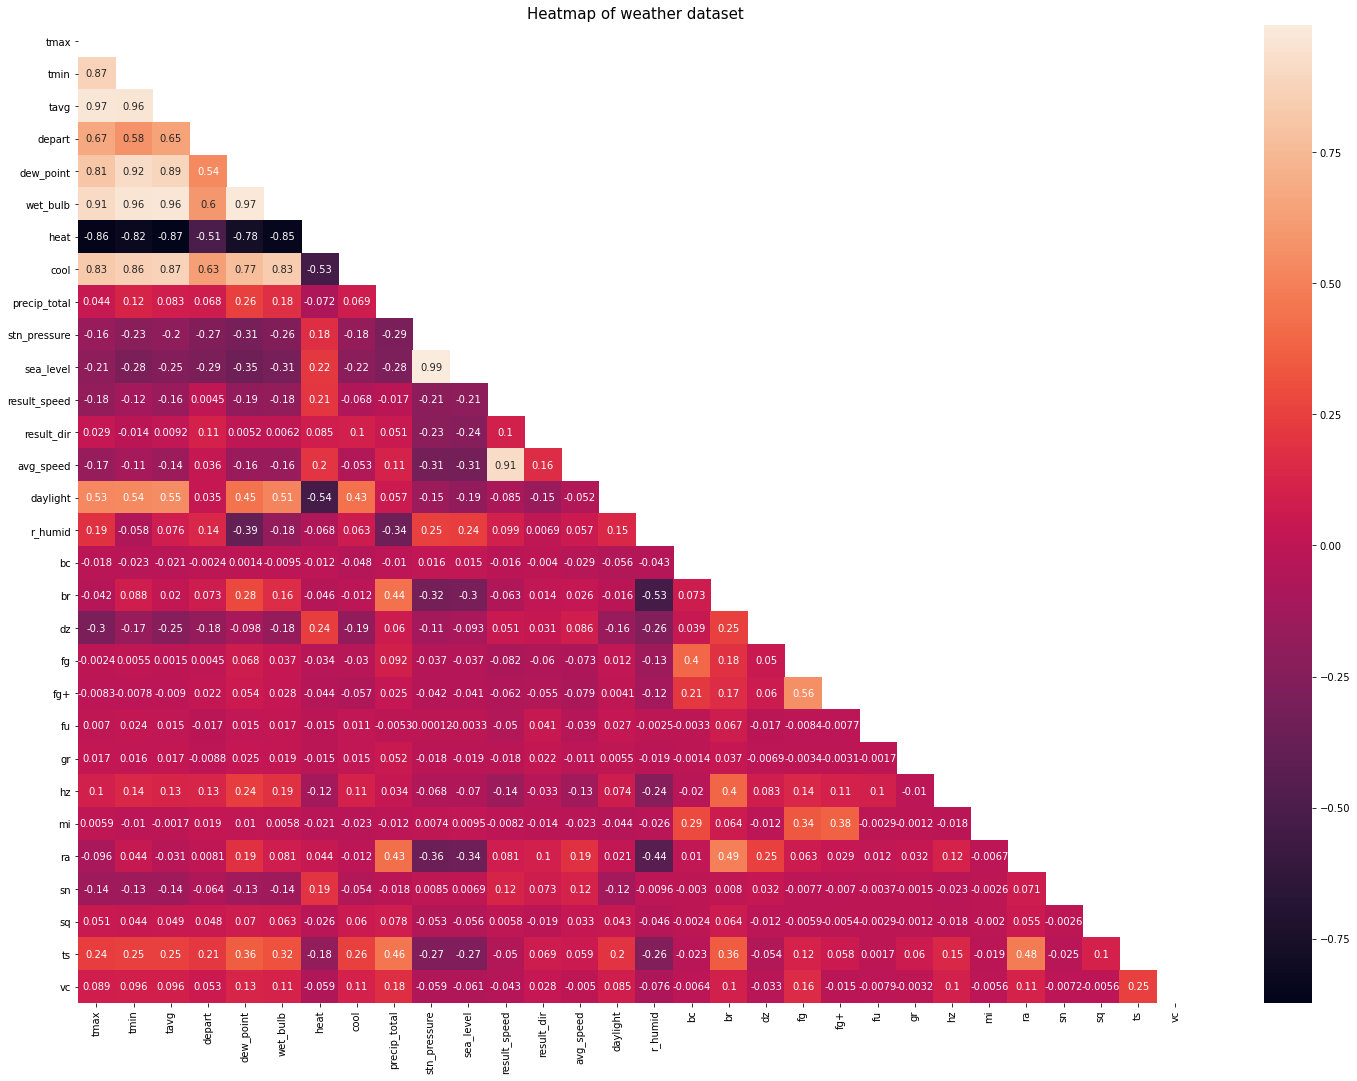

In [76]:
# correlation in weather dataset
plt.figure(figsize=(25,18))
mask = np.triu(weather_final.corr())
sns.heatmap(weather_final.corr(), annot=True, mask=mask);
plt.title('Heatmap of weather dataset', size=15);

#### Rolling Features

Our research shows that breeding cycles are significantly affected by small changes in temperature. For example, the lifecycle of a culex mosquito that takes 14 days at 70° F takes only 10 days at 80° F. (https://www.mosquito.org/page/lifecycle) -> we can use better articles for citation. 

We will look into the rolling average for the following features.

1. 'tavg' which refers to the average temperature

2. 'precip_total' which refers to total precipitation

3. 'r_humid' which refers to relative humidity

In [77]:
features = ['tavg', 'precip_total', 'r_humid']
lag_days = [5, 10, 14, 28]

for feature in features:
    for days in lag_days:
        weather_final[feature+'_'+ str(days)] = weather_final[feature].rolling(days).mean()

### Spray Dataset

Sid, you can insert your codes here with the map

In [78]:
# dates for which spray data is available
spray['date'].unique()

array(['2011-08-29T00:00:00.000000000', '2011-09-07T00:00:00.000000000',
       '2013-07-17T00:00:00.000000000', '2013-07-25T00:00:00.000000000',
       '2013-08-08T00:00:00.000000000', '2013-08-15T00:00:00.000000000',
       '2013-08-16T00:00:00.000000000', '2013-08-22T00:00:00.000000000',
       '2013-08-29T00:00:00.000000000', '2013-09-05T00:00:00.000000000'],
      dtype='datetime64[ns]')

There are only 2 dates in 2011 and 8 dates in 2013 on which the city has some spray data on. The spray is supposed to reduce the growth/population of the mosquito, as cited [here](https://www.cdc.gov/westnile/vectorcontrol/aerial-spraying.html). Let's see if that is what actually happens.

In [79]:
spray['year'] = spray['date'].apply(lambda x: x.year)
spray['month'] = spray['date'].apply(lambda x: x.month)

In [80]:
# plot the 2011 number of mosquito count with spray dates
def plot_spray_data(year):
    plt.figure(figsize=(13, 3))
    plt.title(f"Number of Mosquitos in {year} with spray dates", fontdict={'fontsize': 14})
    plt.plot(train[train['year'] == year].groupby('date')['num_mosquitos'].sum())
    for date in spray[spray['year'] == year]['date'].unique():
        plt.axvline(x=date, ls='--', color='k')

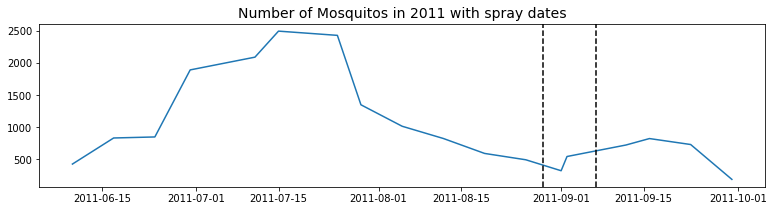

In [81]:
plot_spray_data(2011)

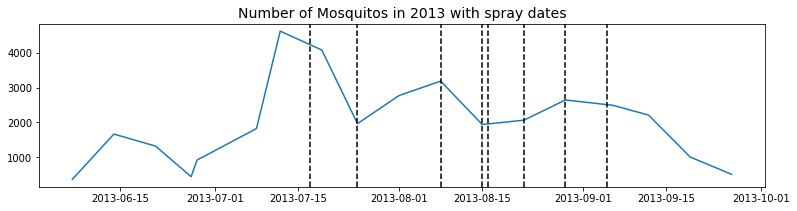

In [82]:
plot_spray_data(2013)

As we can see from the two plots, it cannot be conclusively said that the spraying had any direct effect on the mosquito population. Although, it must be noted that these are the total number of mosquitos and it would make sense to plot the spray data vs mosquito population based on location where it was sprayed. so, let's plot spray data for the two years on the map.

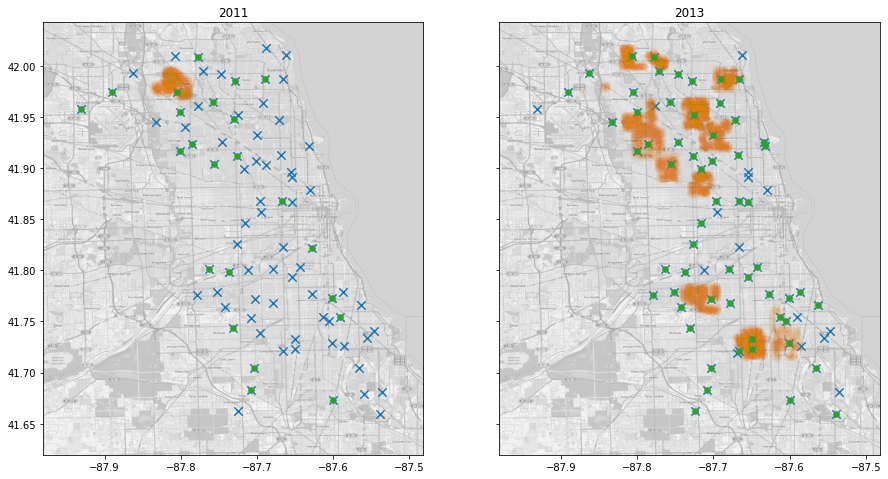

In [83]:
# plot the spray data on location map
spray = spray[spray['longitude'] > min_lon]

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 15*aspect), sharey=True, sharex=True)
# fig.suptitle("Traps with virus and spray data nearby for 2011 and 2013")

for i, year in enumerate(spray['year'].unique()):
    trap_loc = train[train['year'] == year].drop_duplicates('trap')[['trap','longitude', 'latitude', 'wnv_present']]
    
    spray_loc = spray[spray['year'] == year][['date', 'longitude', 'latitude']].drop_duplicates().values

    trap_virus_present = train[(train['year'] == year) & (train['wnv_present'] > 0)].groupby('trap')[
                        ['wnv_present']].mean().sort_values(by='wnv_present', ascending=False)
    
    df = pd.merge(trap_loc.drop(columns='wnv_present'), trap_virus_present, on='trap')

    locations = trap_loc[['longitude', 'latitude']].drop_duplicates().values

    ax[i].imshow(mapdata,
               cmap=plt.get_cmap('gray'), 
               extent=lon_lat_box, 
               aspect=aspect,
               alpha=0.7)
    
    ax[i].scatter(locations[:,0], locations[:,1], marker='x', s=70)
    ax[i].scatter(spray_loc[:,1], spray_loc[:,2], marker='o', s=40, alpha=0.01)
    ax[i].scatter(df.values[:, 1], df.values[:, 2], marker='o', s=30) # , cmap='coolwarm'
    
    ax[i].title.set_text(year)
# plt.tight_layout()
    
    # Add this when copying to a script on Kaggle:
    #plt.savefig('heatmap.png')

Description:

- Spray was only done on 2 years and certain dates
- Epidemic in 2002
- Gov Tech article :'This risk is why the Chicago Department for Public Health (CDPH) established a surveillance and control program in 2004, which includes annual spraying.'
- Annual spraying since 2004, but we only have data set from 2011 and 2013
- Will not use spray in model

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/
https://www.govtech.com/analytics/chicago-turns-to-predictive-analytics-to-map-west-nile-threat.html

In [84]:
# drop the columns
train.drop(columns=['year', 'month', 'trap'], inplace=True)
spray.drop(columns=['year', 'month'], inplace=True)

/home/sid/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Merged Dataset

In [85]:
#merging train and weather
combined = pd.merge(train, weather_final, on='date').drop(columns=['species'])

In [86]:
# split date into day, week, month and year for weather
combined['year'] = combined['date'].dt.year
combined['month'] = combined['date'].dt.month
combined['week'] = combined['date'].dt.isocalendar().week
combined['day'] = combined['date'].dt.dayofweek

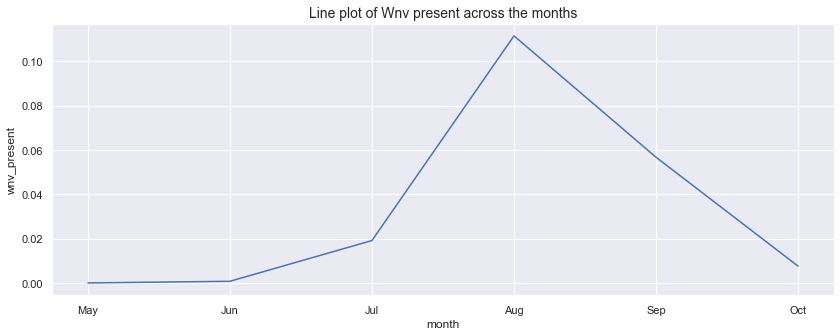

In [87]:
# % Wnv present during the different months
sns.set(rc={'figure.figsize':(14,5)})
sns.lineplot(data=combined, x='month',
             y='wnv_present', ci=None)
plt.title("Line plot of Wnv present across the months", fontdict={'fontsize': 14})
plt.xticks(ticks=[5, 6, 7, 8, 9, 10], labels=['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']);

We see that in the month of August, there are higher number of WNV present.

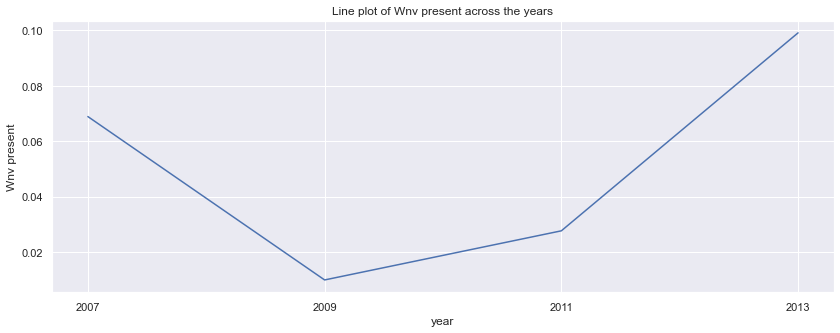

In [88]:
# % Wnv present during the different years
sns.set(rc={'figure.figsize':(14,5)})
sns.lineplot(data=combined, x='year', 
             y='wnv_present', ci=None).set(title='Line plot of Wnv present across the years')
plt.xticks(ticks=[2007, 2009, 2011, 2013])
plt.ylabel('Wnv present');

Presence of WNV dip from 2007 to 2009. However, its started to increase after 2009 and at a higher rate from 2011.

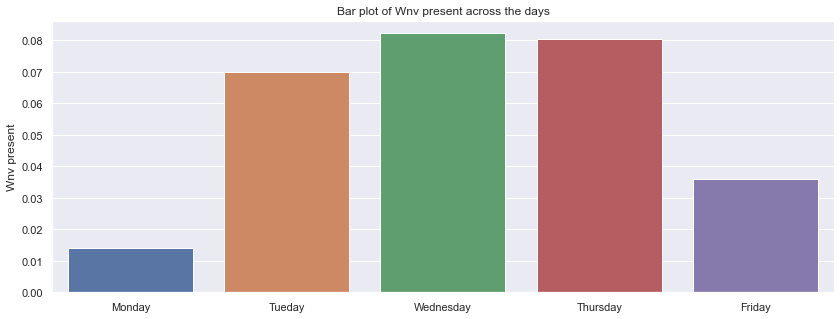

In [89]:
# % Wnv present during the different days
sns.set(rc={'figure.figsize':(14,5)})
sns.barplot(data=combined, 
            x='day', y='wnv_present', ci=None).set(title='Bar plot of Wnv present across the days')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['Monday', 'Tueday', 'Wednesday', 'Thursday', 'Friday'])
plt.xlabel('')
plt.ylabel('Wnv present');

Presence of WNV peaks on Wednesday, followed by Thursday and then Tuesday. There are no data on Saturday and Sunday as probably no data collection has been done due to the weekends.

Top 20 Features that are correlated to Presence of Virus

In [90]:
combined.corr()[['wnv_present']].abs().sort_values('wnv_present',ascending=False)[1:21]

,wnv_present
num_mosquitos,0.232540
tavg_28,0.130653
species_ohe,0.126857
r_humid_14,0.107357
week,0.100982
tavg_14,0.099624
month,0.098732
dew_point,0.094955
r_humid_10,0.092391
wet_bulb,0.092374


Although the number of mosquitos has the highest correlation with the presence of virus, this feature is not a strong indicator of the presence of virus as there is no consistency between the number of mosquitos found in the traps over the years. Additionally, this feature is also not present in our test dataset, hence we will drop this feature. 

In [91]:
combined.drop(columns='num_mosquitos', inplace=True)

In [92]:
combined

,date,latitude,longitude,wnv_present,species_ohe,tmax,tmin,tavg,depart,dew_point,wet_bulb,heat,cool,precip_total,stn_pressure,sea_level,result_speed,result_dir,avg_speed,daylight,r_humid,bc,br,dz,fg,fg+,fu,gr,hz,mi,ra,sn,sq,ts,vc,tavg_5,tavg_10,tavg_14,tavg_28,precip_total_5,precip_total_10,precip_total_14,precip_total_28,r_humid_5,r_humid_10,r_humid_14,r_humid_28,year,month,week,day
0,2007-05-29,41.731922,-87.677512,0,3.0,88.0,62.5,75.5,8.5,58.5,65.5,0.0,10.5,0.0,29.415,30.10,5.80,17.0,6.95,896.0,179.994268,0,1,0,0,0,0,0,1,0,0,0,0,0,0,65.6,67.25,64.678571,63.714286,0.151,0.08575,0.06875,0.055000,172.671291,196.319405,208.835422,207.239818,2007,5,22,1
1,2007-05-29,41.954690,-87.800991,0,2.0,88.0,62.5,75.5,8.5,58.5,65.5,0.0,10.5,0.0,29.415,30.10,5.80,17.0,6.95,896.0,179.994268,0,1,0,0,0,0,0,1,0,0,0,0,0,0,65.6,67.25,64.678571,63.714286,0.151,0.08575,0.06875,0.055000,172.671291,196.319405,208.835422,207.239818,2007,5,22,1
2,2007-05-29,41.974089,-87.824812,0,2.0,88.0,62.5,75.5,8.5,58.5,65.5,0.0,10.5,0.0,29.415,30.10,5.80,17.0,6.95,896.0,179.994268,0,1,0,0,0,0,0,1,0,0,0,0,0,0,65.6,67.25,64.678571,63.714286,0.151,0.08575,0.06875,0.055000,172.671291,196.319405,208.835422,207.239818,2007,5,22,1
3,2007-05-29,41.867108,-87.654224,0,2.0,88.0,62.5,75.5,8.5,58.5,65.5,0.0,10.5,0.0,29.415,30.10,5.80,17.0,6.95,896.0,179.994268,0,1,0,0,0,0,0,1,0,0,0,0,0,0,65.6,67.25,64.678571,63.714286,0.151,0.08575,0.06875,0.055000,172.671291,196.319405,208.835422,207.239818,2007,5,22,1
4,2007-05-29,41.919343,-87.694259,0,2.0,88.0,62.5,75.5,8.5,58.5,65.5,0.0,10.5,0.0,29.415,30.10,5.80,17.0,6.95,896.0,179.994268,0,1,0,0,0,0,0,1,0,0,0,0,0,0,65.6,67.25,64.678571,63.714286,0.151,0.08575,0.06875,0.055000,172.671291,196.319405,208.835422,207.239818,2007,5,22,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8423,2013-09-26,41.803423,-87.642984,0,1.0,75.0,52.5,64.0,2.0,52.0,58.0,1.0,0.0,0.0,29.370,30.04,3.95,8.5,4.40,719.0,153.933102,0,1,0,0,0,0,0,0,0,0,0,0,0,0,61.7,64.50,63.214286,69.428571,0.000,0.09675,0.10125,0.088304,160.851952,153.939384,157.685866,160.038985,2013,9,39,3
8424,2013-09-26,41.750498,-87.605294,0,1.0,75.0,52.5,64.0,2.0,52.0,58.0,1.0,0.0,0.0,29.370,30.04,3.95,8.5,4.40,719.0,153.933102,0,1,0,0,0,0,0,0,0,0,0,0,0,0,61.7,64.50,63.214286,69.428571,0.000,0.09675,0.10125,0.088304,160.851952,153.939384,157.685866,160.038985,2013,9,39,3
8425,2013-09-26,41.740641,-87.546587,0,1.0,75.0,52.5,64.0,2.0,52.0,58.0,1.0,0.0,0.0,29.370,30.04,3.95,8.5,4.40,719.0,153.933102,0,1,0,0,0,0,0,0,0,0,0,0,0,0,61.7,64.50,63.214286,69.428571,0.000,0.09675,0.10125,0.088304,160.851952,153.939384,157.685866,160.038985,2013,9,39,3
8426,2013-09-26,41.963976,-87.691810,0,1.0,75.0,52.5,64.0,2.0,52.0,58.0,1.0,0.0,0.0,29.370,30.04,3.95,8.5,4.40,719.0,153.933102,0,1,0,0,0,0,0,0,0,0,0,0,0,0,61.7,64.50,63.214286,69.428571,0.000,0.09675,0.10125,0.088304,160.851952,153.939384,157.685866,160.038985,2013,9,39,3


### Test Dataset

We will one hot encode the species column for the test dataset as well.

In [93]:
#one hot encode species
test['species_ohe'] = test['species'].map(
    {'CULEX RESTUANS': 1, 'CULEX PIPIENS/RESTUANS': 2, 'CULEX PIPIENS': 3})
#0 for all other species
test['species_ohe'].fillna(0, inplace=True)

In [94]:
test.drop(columns={'species', 'trap'}, inplace=True)

In [95]:
test_combined = pd.merge(test, weather_final, on='date')

In [96]:
# split date into day, week, month and year
test_combined['year'] = test_combined['date'].dt.year
test_combined['month'] = test_combined['date'].dt.month
test_combined['week'] = test_combined['date'].dt.isocalendar().week
test_combined['day'] = test_combined['date'].dt.dayofweek

## Export Cleaned Data

In [97]:
combined.to_csv('../datasets/combined_cleaned.csv', index=False)

In [98]:
test_combined.to_csv('../datasets/test_cleaned.csv', index=False)